## Libraries

In [6]:
!pip install shap

In [7]:
pip install sklearn

In [8]:
pip install optuna

In [102]:
# import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import xgboost as xgb
import shap
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report

%matplotlib inline
import lightgbm as lgbm
from lightgbm import  log_evaluation, early_stopping
import optuna
from optuna.integration import LightGBMPruningCallback

import pickle
import sklearn

## Data Processing and Feature Selection

For the feature selection, I started off with dropping columns that have low correlation (< 0.4) with SalePrice. I then dropped columns with low variances (< 1). After that I checked the correlation matrix between columns to dropped selected columns that have correlation greater than 0.5 but with consideration for domain knowledge. After that I checked for NAs in the numerical columns. Then, based on the result, I used domain knowledge to fill the NAs with appropriate value. In this case, I used 0 to fill the NAs as it was the most relevant value. As for the categorical NAs, they were replaced with ‘None’. Once, all the NAs were taken cared of, I used LabelEncoder to encode the categorical values. I, then, checked for correlation between columns and dropped them based on domain knowledge.

link to the data: https://drive.google.com/drive/folders/1oml9pTxlzrMBt7qZRe2KSV8dkNkbEXvK?usp=sharing

#### Importing Data

In [179]:
dataset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')

#### Examining train dataset

In [180]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### Setting y to the label column (numpy array)

In [181]:
y = dataset['SalePrice'].values
#type(y)

#### Making a new dataframe without SalePrice

In [182]:
X_start = dataset.drop(['SalePrice'], axis = 1)
X_start.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


#### Checking for columns with low correlation (< 0.4) with SalePrice and dropping them

In [183]:
price_corr = dataset.corr()['SalePrice']

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


In [184]:
low_corr = price_corr[abs(price_corr) < 0.4].sort_values(ascending=False)

In [185]:
low_corr

BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [186]:
for i in low_corr.index:
    X_start.drop(i, axis = 1, inplace = True)
    testset.drop(i, axis = 1, inplace = True)

In [187]:
X_start.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,2,548,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,2,460,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,2,608,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,3,642,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,3,836,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### Checking for columns with low variance (< 1) and dropping them

In [188]:
variance = X_start.var()

The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


In [189]:
low_var = variance[(variance) < 1].sort_values(ascending = True)

In [190]:
low_var

FullBath      0.303508
Fireplaces    0.415595
GarageCars    0.558480
dtype: float64

In [191]:
for i in low_var.index:
    X_start.drop(i, axis = 1, inplace = True)
    testset.drop(i, axis = 1, inplace = True)

In [192]:
X_start.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,RFn,548,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,RFn,460,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,RFn,608,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Unf,642,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,RFn,836,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### Checking to correlation between columns and dropping selected columns based on domain knowledge

In [193]:
correlation = X_start.corr().abs()
corr_list = (correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
            .stack())
high_corr = corr_list.loc[corr_list > 0.5]

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


In [194]:
high_corr

OverallQual   YearBuilt       0.572323
              YearRemodAdd    0.550684
              TotalBsmtSF     0.537808
              GrLivArea       0.593007
              GarageYrBlt     0.547766
              GarageArea      0.562022
YearBuilt     YearRemodAdd    0.592855
              GarageYrBlt     0.825667
YearRemodAdd  GarageYrBlt     0.642277
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      GrLivArea       0.566024
GrLivArea     TotRmsAbvGrd    0.825489
GarageYrBlt   GarageArea      0.564567
dtype: float64

In [195]:
drop_hico = ['GarageArea', 'TotRmsAbvGrd', '1stFlrSF', 'GarageYrBlt', 'YearRemodAdd']

In [196]:
X_start = X_start.drop(drop_hico, axis = 1)
testset = testset.drop(drop_hico, axis = 1)

In [197]:
X_start.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### Identifiying numerical and categorical values for replacing NAs with appropriate values

In [198]:
numerical = X_start.select_dtypes(include=['number'])
categorical = X_start.select_dtypes(include=['object'])
t_numerical = testset.select_dtypes(include=['number'])
t_categorical = testset.select_dtypes(include=['object'])

In [199]:
numerical.head()

,OverallQual,YearBuilt,MasVnrArea,TotalBsmtSF,GrLivArea
0,7,2003,196.0,856,1710
1,6,1976,0.0,1262,1262
2,7,2001,162.0,920,1786
3,7,1915,0.0,756,1717
4,8,2000,350.0,1145,2198


In [200]:
categorical

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [201]:
num_na = numerical.columns[numerical.isnull().any()]
num_na

Index(['MasVnrArea'], dtype='object')

#### Based on domain knowledge, NAs in MasVrArea is replaced with 0

In [202]:
for n in [num_na]:
    X_start[n] = X_start[n].fillna(0)

In [203]:
t_num_na = t_numerical.columns[t_numerical.isnull().any()]
t_num_na

Index(['MasVnrArea', 'TotalBsmtSF'], dtype='object')

In [204]:
for n in [t_num_na]:
    testset[n] = testset[n].fillna(0)

In [205]:
categorical.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### For categorical NAs, they were replaced with None

In [206]:
cat_na = categorical.columns[categorical.isnull().any()]
cat_na

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

In [207]:
for c in [cat_na]:
    X_start[c] = X_start[c].fillna('None')
    categorical[c] = categorical[c].fillna('None')

In [208]:
t_cat_na = t_categorical.columns[t_categorical.isnull().any()]
t_cat_na

Index(['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')

In [209]:
for c in [t_cat_na]:
    testset[c] = testset[c].fillna('None')
    t_categorical[c] = t_categorical[c].fillna('None')

In [210]:
categorical.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


#### Checking to see if they are any NAs left

In [211]:
X_start.isnull().values.any()

False

In [212]:
testset.isnull().values.any()

False

#### Label encoding of categorical data

In [213]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feature in categorical.columns:
    X_start[feature]=le.fit_transform(X_start[feature])
    categorical[feature]=le.fit_transform(categorical[feature])
    testset[feature]=le.fit_transform(testset[feature])
    t_categorical[feature]=le.fit_transform(t_categorical[feature])

In [214]:
categorical.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,3,1,1,3,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
1,3,1,1,3,3,0,2,0,24,1,...,1,2,5,5,2,3,4,1,8,4
2,3,1,1,0,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
3,3,1,1,0,3,0,0,0,6,2,...,5,3,5,5,2,3,4,1,8,0
4,3,1,1,0,3,0,2,0,15,2,...,1,2,5,5,2,3,4,1,8,4


#### Checking for correlation between categorial columns and dropping highly correlated items based on domain knowledge

In [215]:
cat_corr = categorical.corr().abs()
cat_corr_list = (cat_corr.where(np.triu(np.ones(cat_corr.shape), k=1).astype(bool))
            .stack())
high_cat_corr = cat_corr_list.loc[cat_corr_list > 0.5]

In [216]:
high_cat_corr

Exterior1st  Exterior2nd    0.854163
ExterQual    BsmtQual       0.572327
             KitchenQual    0.641584
GarageQual   GarageCond     0.618383
dtype: float64

In [217]:
drop_hcc = ['GarageCond', 'BsmtQual', 'KitchenQual', 'Exterior2nd']

In [218]:
X_start = X_start.drop(drop_hcc, axis = 1)
testset = testset.drop(drop_hcc, axis = 1)

In [219]:
X_start.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,FireplaceQu,GarageType,GarageFinish,GarageQual,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,3,1,1,3,3,0,4,0,5,2,...,3,1,2,5,2,3,4,1,8,4
1,3,1,1,3,3,0,2,0,24,1,...,5,1,2,5,2,3,4,1,8,4
2,3,1,1,0,3,0,4,0,5,2,...,5,1,2,5,2,3,4,1,8,4
3,3,1,1,0,3,0,0,0,6,2,...,2,5,3,5,2,3,4,1,8,0
4,3,1,1,0,3,0,2,0,15,2,...,5,1,2,5,2,3,4,1,8,4


#### Normalizing data

In [220]:
X_start = (X_start - X_start.min()) / (X_start.max() - X_start.min())
testset = (testset - testset.min()) / (testset.max() - testset.min())

In [221]:
dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Using Decision Tree (Random Forest) to selected the 10 best features

In [222]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(X_start,y)

RandomForestRegressor(max_depth=10, random_state=1)

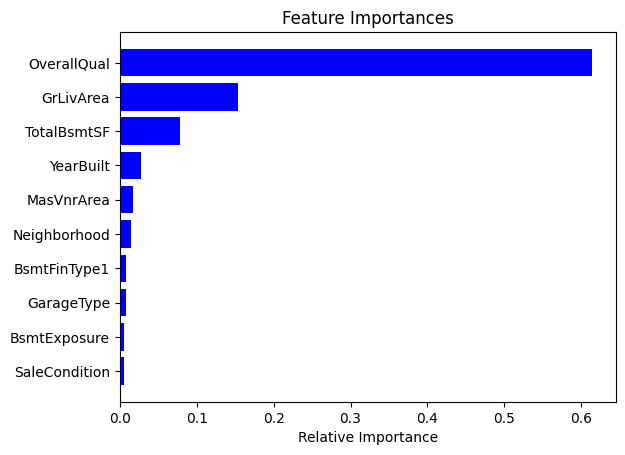

In [223]:
features = X_start.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [224]:
feat = dict(reversed(sorted(zip(model.feature_importances_, X_start.columns.values))))

In [225]:
feat10 = [feat[x] for x in list(feat)[:10]]

In [226]:
t_drop = [feat[x] for x in list(feat)[10:]]

In [227]:
for i in t_drop:
    testset.drop(i, axis = 1, inplace = True)

In [228]:
testset.shape

(1459, 10)

In [229]:
X = X_start[feat10].copy()

In [230]:
X.head()

,OverallQual,GrLivArea,TotalBsmtSF,YearBuilt,MasVnrArea,Neighborhood,BsmtFinType1,GarageType,BsmtExposure,SaleCondition
0,0.666667,0.259231,0.140098,0.949275,0.12250,0.208333,0.333333,0.166667,0.75,0.8
1,0.555556,0.174830,0.206547,0.753623,0.00000,1.000000,0.000000,0.166667,0.25,0.8
2,0.666667,0.273549,0.150573,0.934783,0.10125,0.208333,0.333333,0.166667,0.50,0.8
3,0.666667,0.260550,0.123732,0.311594,0.00000,0.250000,0.000000,0.833333,0.75,0.0
4,0.777778,0.351168,0.187398,0.927536,0.21875,0.625000,0.333333,0.166667,0.00,0.8


In [231]:
y

array([208500, 181500, 223500, ..., 266500, 142125, 147500])

#### Spiliting the training data for testing purposes

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Getting the categorical features

In [233]:
categorical_features = []
for col in X.columns:
    if X[col].dtype == "object":
        categorical_features.append(col)

In [234]:
# Cat feature indices on X
cat_indices = []
for c in categorical_features:
    if c in X.columns:
        idx = list(X.columns).index(c)
        cat_indices.append(idx)

##XGBoost Model

In [235]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",max_depth=3)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### testing the model

In [236]:
xgbt_pred = xgb_model.predict(X_test)
print("MAE test score:", int(mean_absolute_error(y_test, xgbt_pred)))
print("MSE test score:", int(mean_squared_error(y_test, xgbt_pred)))
print("RMSE test score:", int(sqrt(mean_squared_error(y_test, xgbt_pred))))

MAE test score: 18490
MSE test score: 840217398
RMSE test score: 28986


In [237]:
y_test.mean()

181370.38356164383

Discussion: Mean absoute error and (root) mean square error difference between the predicted price and the ground truth are shown to show how the model performs.

## SHAP for XGBoost

In [238]:
explainer = shap.TreeExplainer(xgb_model)
shap_interaction = explainer.shap_interaction_values(X_train)
# Get SHAP values
shap_values = explainer(X_train)

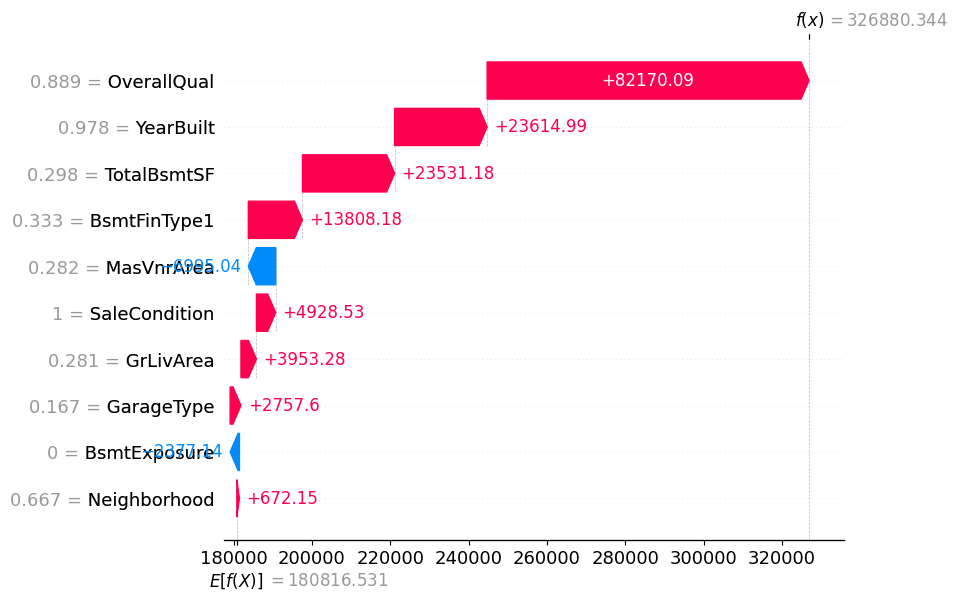

In [239]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

**Discussion**

This waterfall plot shows which feature contributes how much to the predicted price. The Overall Quality has the highest attribution to the predicted price in this model, followed by Year Built, Total Basement Squre Foot, etc. But the Masonry veneer type and Basement Exposure, which refers to walkout or garden level walls, reduces the predicted price.

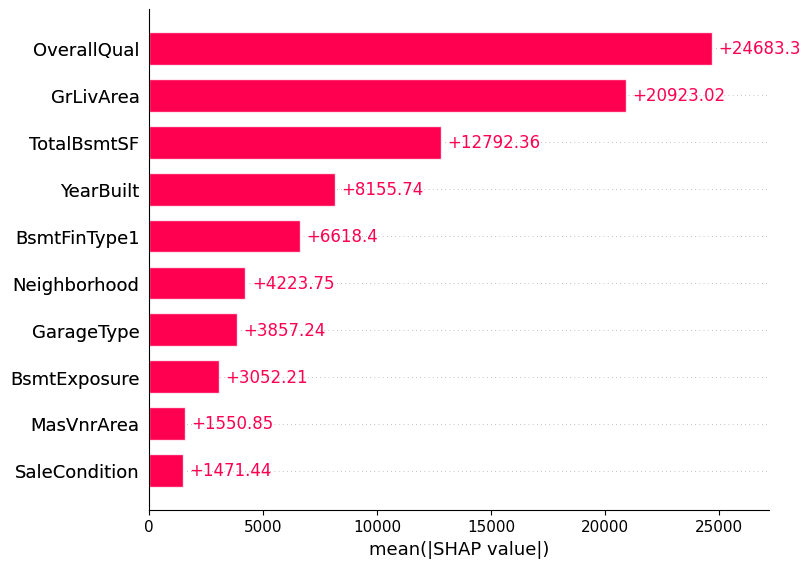

In [240]:
#Mean SHAP
shap.plots.bar(shap_values)

**Discussion**

This mean SHAP value plot tells us which features are the most important by find the mean values across all observations instead of positive and negative offsets. You can see from the above plot that Overall Quality, Above grade (ground) living area square feet, and Total square feet of basement area made the most significant impact on the model’s predictions.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


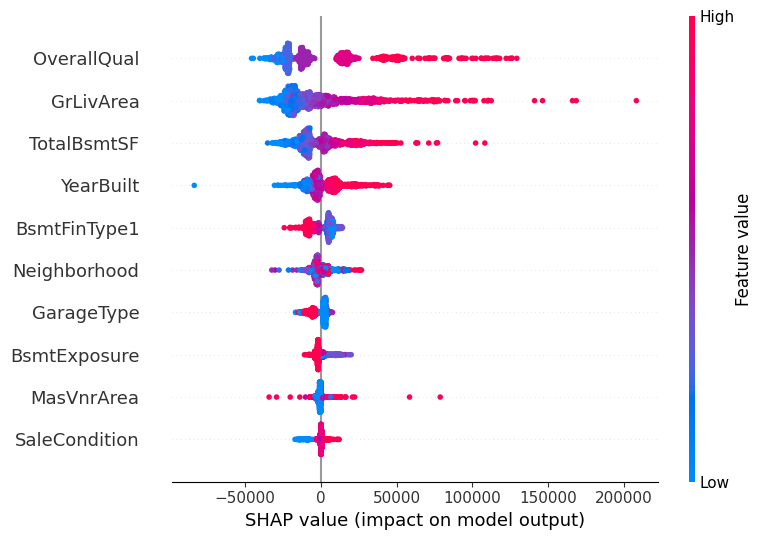

In [241]:
#Display summary plot
shap.summary_plot(shap_values, X_train)

**Discussion**

This summary plot visualises all of the SHAP values. On the y-axis, the values are grouped by feature and higher feature values are redder. This plot highlights important relationships: for example, for the Overall Quality and Above grade (ground) living area square feet, as the feature value increases the SHAP values increase. But for the Basement Exposure, which refers to walkout or garden level walls, has the opposite relationship.
From these Beeswarm plots, we can also see where the high density SHAP values are because the points are vertically stacked.

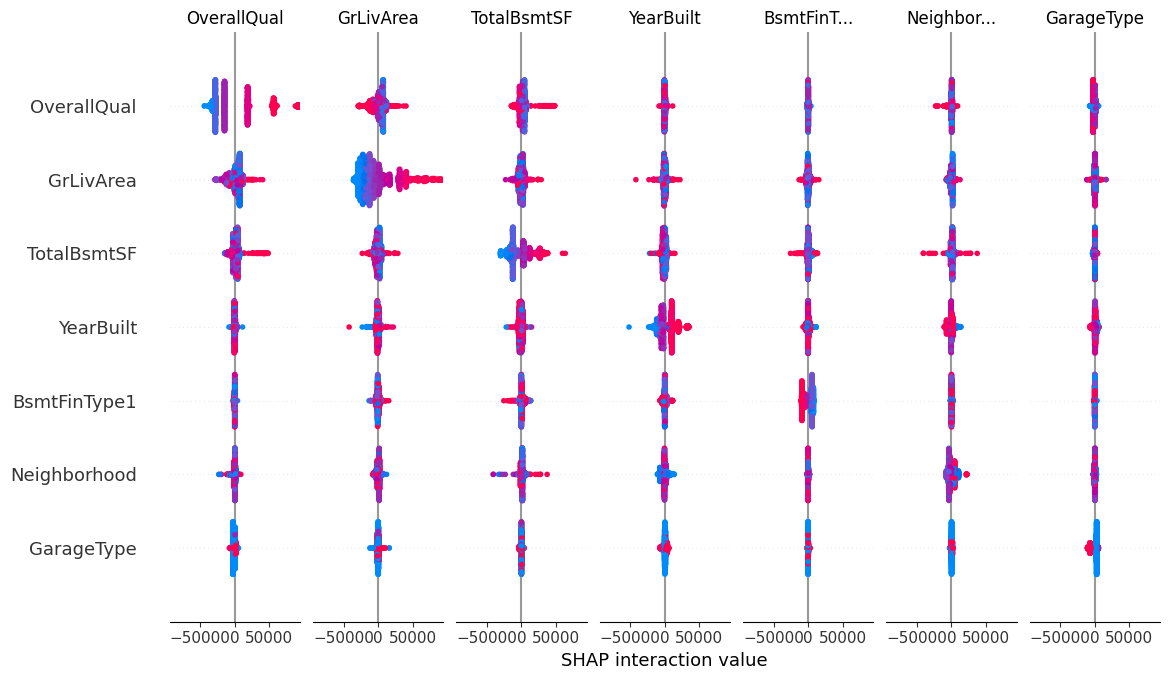

In [242]:
#Display summary plot
shap.summary_plot(shap_interaction, X_train)

**Discussion**

This summary plot gives additional insight through visualizing the relationship between features and their SHAP interaction values. As we can see, certain features tend to have a more significiant impact on the prediction, and the distributions of the plots tell us which interactions are more significant than others. For example, Overall Quality, Above Ground Living Area, Total Basement Square Foot, and Neighborhood.

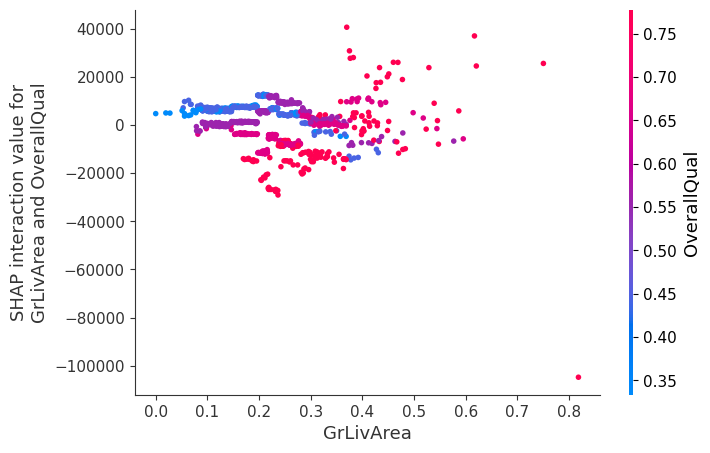

In [243]:
# OverallQual-GrLivArea depenence plot
shap.dependence_plot(
    ("GrLivArea", "OverallQual"),
    shap_interaction, X_train,
    display_features = X_train)

**Discussion**

Given a relatively high overall quality, bigger above ground living area increase the SHAP interaction value. However, when the overall quality of the home is low or medium, change in SHAP interaction value is not as pronounced.

##Tuning XGBoostWIthOptuna

In [246]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [247]:
# Create the study
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=100)


[I 2023-07-23 03:50:25,430] A new study created in memory with name: regression
[I 2023-07-23 03:50:25,525] Trial 0 finished with value: 13358775628.102783 and parameters: {'max_depth': 8, 'learning_rate': 0.7967697991002506, 'n_estimators': 76, 'min_child_weight': 6, 'gamma': 0.729547355260913, 'subsample': 0.1921452589342656, 'colsample_bytree': 0.4922451273737446, 'reg_alpha': 0.18890583791277304, 'reg_lambda': 0.6744945519044583, 'random_state': 210}. Best is trial 0 with value: 13358775628.102783.
[I 2023-07-23 03:50:25,730] Trial 1 finished with value: 1431332444.0111012 and parameters: {'max_depth': 1, 'learning_rate': 0.752928204647888, 'n_estimators': 581, 'min_child_weight': 10, 'gamma': 0.6755342827153574, 'subsample': 0.7126149213544195, 'colsample_bytree': 0.10003821342444509, 'reg_alpha': 0.839033660752902, 'reg_lambda': 0.749196748998681, 'random_state': 573}. Best is trial 1 with value: 1431332444.0111012.
[I 2023-07-23 03:50:26,579] Trial 2 finished with value: 1173600

In [248]:
# Print the best parameters
print('Best parameters', study.best_params)

Best parameters {'max_depth': 2, 'learning_rate': 0.12725278676355972, 'n_estimators': 645, 'min_child_weight': 1, 'gamma': 0.03913120415720357, 'subsample': 0.8728192285358491, 'colsample_bytree': 0.4267925489922823, 'reg_alpha': 0.3947596527993052, 'reg_lambda': 0.4185596117742408, 'random_state': 782}


In [249]:
# Print the best value
print('Best value', study.best_value)

Best value 786666806.8943005


In [250]:
# Print the best trial
print('Best trial', study.best_trial)

Best trial FrozenTrial(number=83, state=TrialState.COMPLETE, values=[786666806.8943005], datetime_start=datetime.datetime(2023, 7, 23, 3, 51, 21, 877354), datetime_complete=datetime.datetime(2023, 7, 23, 3, 51, 22, 280771), params={'max_depth': 2, 'learning_rate': 0.12725278676355972, 'n_estimators': 645, 'min_child_weight': 1, 'gamma': 0.03913120415720357, 'subsample': 0.8728192285358491, 'colsample_bytree': 0.4267925489922823, 'reg_alpha': 0.3947596527993052, 'reg_lambda': 0.4185596117742408, 'random_state': 782}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=50, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'gamma': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False,

##Optimized XGBoost

In [251]:
xgb_optimized = xgb.XGBRegressor(**study.best_params)
xgb_optimized.fit(X_train, y_train)
y_pred = xgb_optimized.predict(X_test)

print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

MSE:  786666806.8943005
RMSE:  28047.58112376717


## SHAP for XGBoost Optimized

In [252]:
explainer_xgb = shap.TreeExplainer(xgb_optimized)
shap_interaction_xgb = explainer_xgb.shap_interaction_values(X_train)
# Get SHAP values
shap_values_xgb = explainer_xgb(X_train)

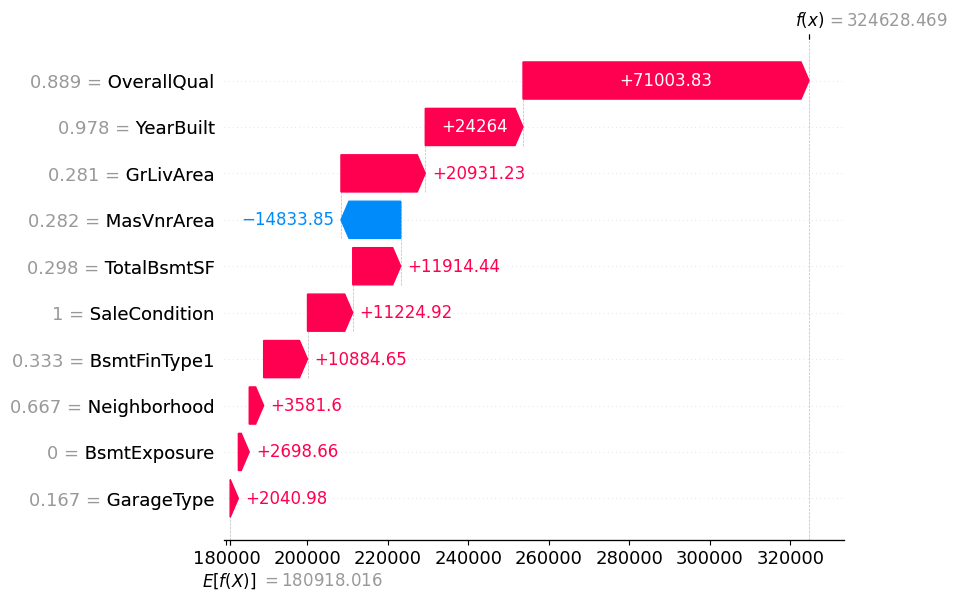

In [253]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values_xgb[0])

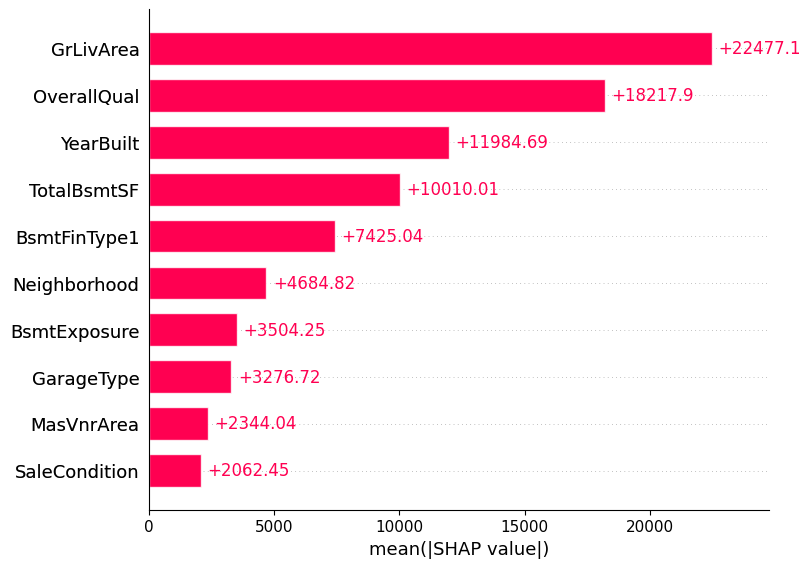

In [254]:
#Mean SHAP
shap.plots.bar(shap_values_xgb)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


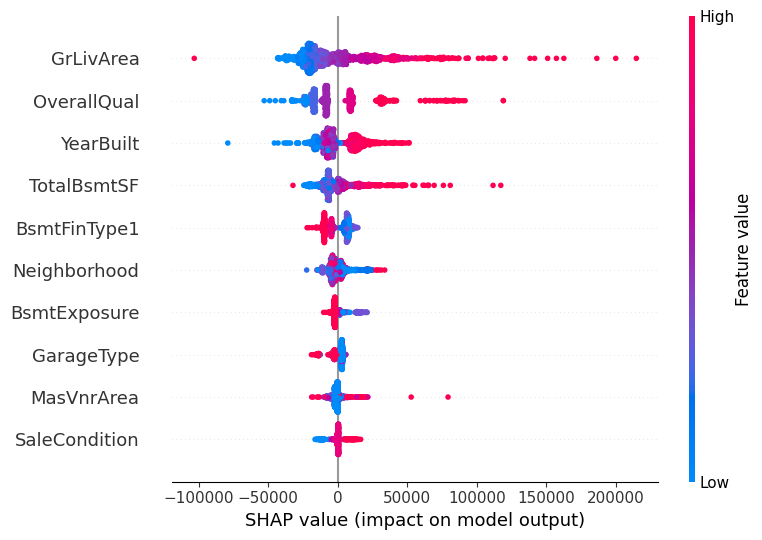

In [255]:
#Display summary plot
shap.summary_plot(shap_values_xgb, X_train)

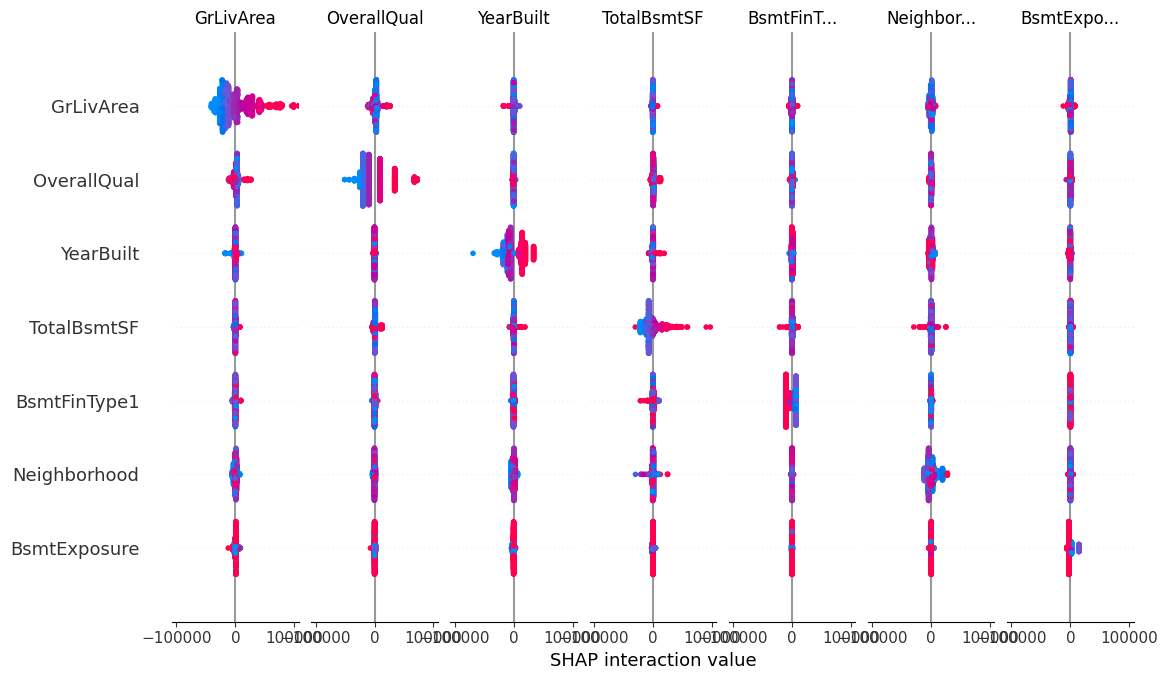

In [256]:
#Display summary plot
shap.summary_plot(shap_interaction_xgb, X_train)

##Light Gradient Boosting Machine (LGBM) (Baseline)

This is the Baseline.

In [257]:
reg_lgbm_baseline = lgbm.LGBMRegressor()  # default - 'regression'

In [258]:
reg_lgbm_baseline.fit(X_train, y_train)

LGBMRegressor()

In [259]:
lgbm_predict = reg_lgbm_baseline.predict(X_test)

In [260]:
print("MAE test score:", int(mean_absolute_error(y_test, lgbm_predict)))
print("MSE test score:", int(mean_squared_error(y_test, lgbm_predict)))
print("RMSE test score:", int(sqrt(mean_squared_error(y_test, lgbm_predict))))

MAE test score: 18418
MSE test score: 1163546281
RMSE test score: 34110


In [261]:
y_test.mean()

181370.38356164383

**Discussion:**

I did XGBoost for milestone-2 and switch to LGBMRegressor for milestone-3 and the baseline model is already better than the XGBoost, with RMSE = 26233.

###SHAP for LGBM baseline

In [262]:
explainer_lgbm_baseline = shap.TreeExplainer(reg_lgbm_baseline)
shap_interaction_lgbm_baseline = explainer_lgbm_baseline.shap_interaction_values(X_train)
# Get SHAP values
shap_values_lgbm_baseline = explainer_lgbm_baseline(X_train)

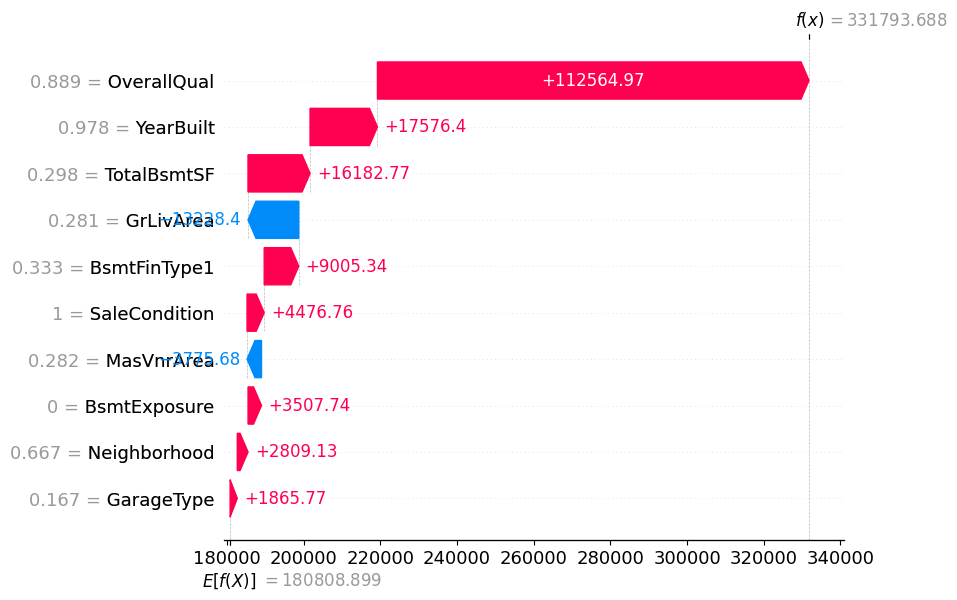

In [263]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values_lgbm_baseline[0])

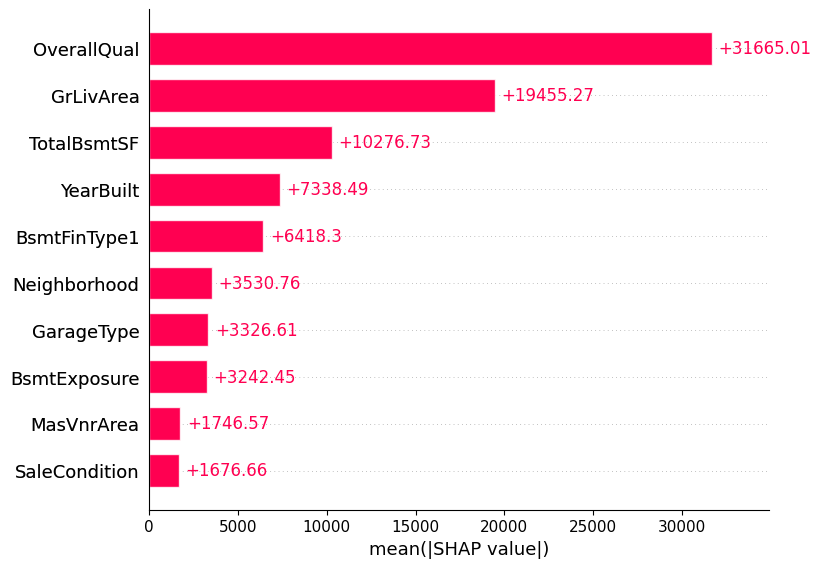

In [264]:
#Mean SHAP
shap.plots.bar(shap_values_lgbm_baseline)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


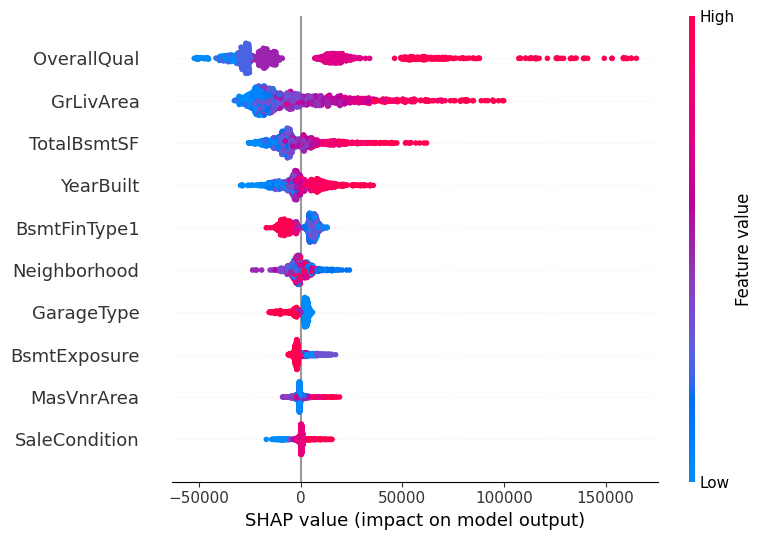

In [265]:
#Display summary plot
shap.summary_plot(shap_values_lgbm_baseline, X_train)

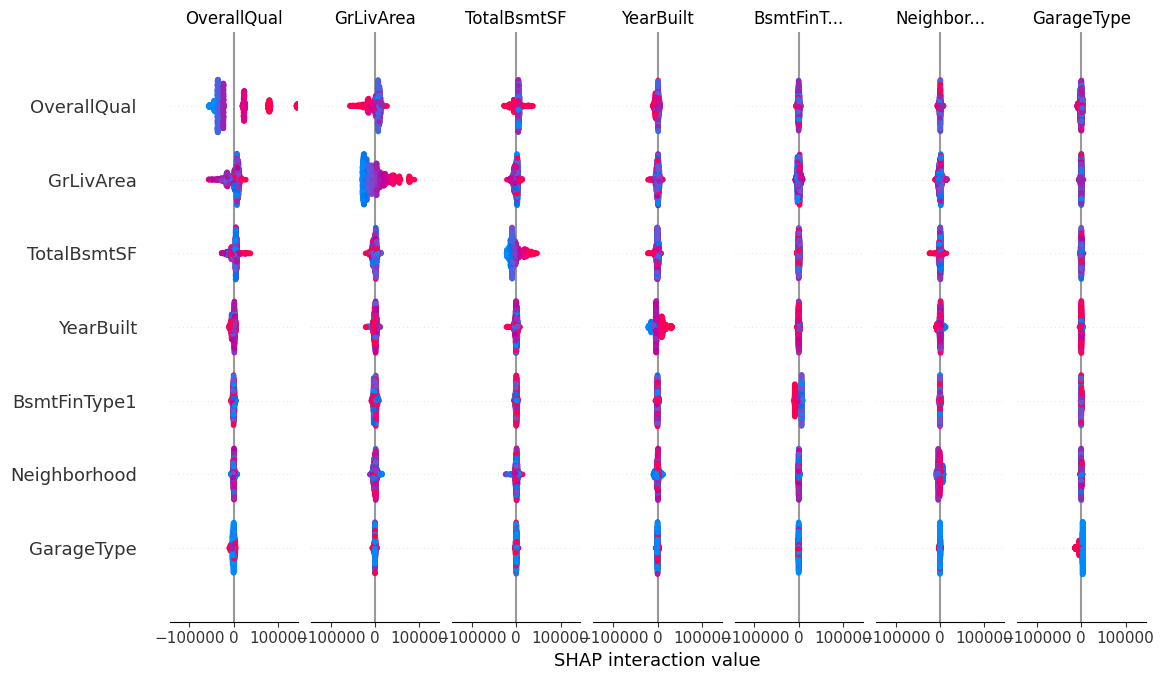

In [266]:
#Display summary plot
shap.summary_plot(shap_interaction_lgbm_baseline, X_train)

##Tuning LGBM with Optuna

In [267]:
def objective(trial, data=X,target=y):

    params = {
                'metric': 'rmse',
                'random_state': 22,
                'n_estimators': 20000,
                'boosting_type': trial.suggest_categorical("boosting_type", ["gbdt", "goss"]),
                'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
                'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
                'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
                'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.85, 1.0]),
                'learning_rate': trial.suggest_categorical('learning_rate', [0.005, 0.01, 0.02, 0.03, 0.05, 0.1]),
                'max_depth': trial.suggest_int('max_depth', 2, 12, step=1),
                'num_leaves' : trial.suggest_int('num_leaves', 13, 148, step=5),
                'min_child_samples': trial.suggest_int('min_child_samples', 1, 96, step=5),
            }
    reg = lgbm.LGBMRegressor(**params)
    reg.fit(X_train ,y_train,
            eval_set=[(X_test, y_test)],
            #categorical_feature=cat_indices,
            callbacks=[log_evaluation(period=1000),
                       early_stopping(stopping_rounds=50)
                      ],
           )

    y_pred = reg.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return rmse

In [268]:
params_search = True
# # Optuna: run study trials

if params_search:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=120)

[I 2023-07-23 03:54:54,693] A new study created in memory with name: no-name-eb6d4604-8803-4ca1-83a7-055f87f5b2ee
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[569]	valid_0's rmse: 37469.8


[I 2023-07-23 03:54:54,985] Trial 0 finished with value: 37469.83254761123 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.0013527302206814348, 'reg_lambda': 0.08262940130729987, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 18, 'min_child_samples': 81}. Best is trial 0 with value: 37469.83254761123.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 33735.1
[2000]	valid_0's rmse: 32595.3
[3000]	valid_0's rmse: 32015.8
Early stopping, best iteration is:
[3194]	valid_0's rmse: 31915.2


[I 2023-07-23 03:54:57,743] Trial 1 finished with value: 31915.245718517377 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 4.219924923960138, 'reg_lambda': 4.075462128014512, 'colsample_bytree': 0.7, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 11, 'num_leaves': 33, 'min_child_samples': 41}. Best is trial 1 with value: 31915.245718517377.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 35473.6
Early stopping, best iteration is:
[1000]	valid_0's rmse: 35473.6


[I 2023-07-23 03:54:58,803] Trial 2 finished with value: 35473.581411211926 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 0.01731772133203689, 'reg_lambda': 7.303543595421454, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.005, 'max_depth': 12, 'num_leaves': 108, 'min_child_samples': 11}. Best is trial 1 with value: 31915.245718517377.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 31921.3
Early stopping, best iteration is:
[1079]	valid_0's rmse: 31782.4


[I 2023-07-23 03:54:59,772] Trial 3 finished with value: 31782.43742342515 and parameters: {'boosting_type': 'goss', 'reg_alpha': 9.937853452832918, 'reg_lambda': 0.005736792462315888, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 93, 'min_child_samples': 11}. Best is trial 3 with value: 31782.43742342515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[883]	valid_0's rmse: 32983.1


[I 2023-07-23 03:55:00,484] Trial 4 finished with value: 32983.05815024558 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 3.17733582908792, 'reg_lambda': 0.1577019409740968, 'colsample_bytree': 0.8, 'subsample': 0.85, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 148, 'min_child_samples': 41}. Best is trial 3 with value: 31782.43742342515.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:00,905] Trial 5 finished with value: 31680.314798159856 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.003100758182483704, 'reg_lambda': 0.029277980365076194, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 11, 'num_leaves': 123, 'min_child_samples': 16}. Best is trial 5 with value: 31680.314798159856.


Early stopping, best iteration is:
[341]	valid_0's rmse: 31680.3
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[1000]	valid_0's rmse: 38464.3
[2000]	valid_0's rmse: 37419.4
[3000]	valid_0's rmse: 36425.3
[4000]	valid_0's rmse: 36019.7
[5000]	valid_0's rmse: 35755.1
[6000]	valid_0's rmse: 35350
Early stopping, best iteration is:
[6561]	valid_0's rmse: 35166.2


[I 2023-07-23 03:55:03,548] Trial 6 finished with value: 35166.23495091295 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 2.4056256989381697, 'reg_lambda': 0.23916802818415075, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.005, 'max_depth': 3, 'num_leaves': 138, 'min_child_samples': 71}. Best is trial 5 with value: 31680.314798159856.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:55:03,732] Trial 7 finished with value: 33204.89757979411 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.021164248256888975, 'reg_lambda': 0.0012201572471750542, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.1, 'max_

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[333]	valid_0's rmse: 33204.9
Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:04,001] Trial 8 finished with value: 32836.927019211085 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 0.0033121109667487996, 'reg_lambda': 2.920075813970546, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'num_leaves': 28, 'min_child_samples': 31}. Best is trial 5 with value: 31680.314798159856.


Early stopping, best iteration is:
[706]	valid_0's rmse: 32836.9
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[1000]	valid_0's rmse: 37817.4
[2000]	valid_0's rmse: 36765.3
[3000]	valid_0's rmse: 35966.7
[4000]	valid_0's rmse: 35288.7
Early stopping, best iteration is:
[4557]	valid_0's rmse: 34984.8


[I 2023-07-23 03:55:05,885] Trial 9 finished with value: 34984.8001380341 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 0.009318333753746164, 'reg_lambda': 0.613097412260877, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.005, 'max_depth': 6, 'num_leaves': 18, 'min_child_samples': 56}. Best is trial 5 with value: 31680.314798159856.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[572]	valid_0's rmse: 29474.6


[I 2023-07-23 03:55:06,849] Trial 10 finished with value: 29474.6331766052 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.13868168208452053, 'reg_lambda': 0.01883004988578201, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 58, 'min_child_samples': 1}. Best is trial 10 with value: 29474.6331766052.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[637]	valid_0's rmse: 29666


[I 2023-07-23 03:55:08,523] Trial 11 finished with value: 29665.957571620143 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.1360015514002235, 'reg_lambda': 0.02205668826458862, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 68, 'min_child_samples': 1}. Best is trial 10 with value: 29474.6331766052.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[562]	valid_0's rmse: 29504.1


[I 2023-07-23 03:55:10,180] Trial 12 finished with value: 29504.123865194142 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.22486067289627334, 'reg_lambda': 0.027059529840937055, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 58, 'min_child_samples': 1}. Best is trial 10 with value: 29474.6331766052.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 35704.5
[2000]	valid_0's rmse: 34798.7
Early stopping, best iteration is:
[2001]	valid_0's rmse: 34798


[I 2023-07-23 03:55:11,366] Trial 13 finished with value: 34798.0459143028 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.2399666309733721, 'reg_lambda': 0.012250356156366157, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 58, 'min_child_samples': 26}. Best is trial 10 with value: 29474.6331766052.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 43575.3
[2000]	valid_0's rmse: 42261.6
Early stopping, best iteration is:
[2947]	valid_0's rmse: 41532.6


[I 2023-07-23 03:55:12,203] Trial 14 finished with value: 41532.6014284288 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.3133776452407832, 'reg_lambda': 0.005916025436999573, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 48, 'min_child_samples': 96}. Best is trial 10 with value: 29474.6331766052.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 33906.9
[2000]	valid_0's rmse: 31749.8
[3000]	valid_0's rmse: 30380.4
Early stopping, best iteration is:
[3308]	valid_0's rmse: 30080.1


[I 2023-07-23 03:55:13,163] Trial 15 finished with value: 30080.140640383852 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.05375988121379905, 'reg_lambda': 0.05189608395128428, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 2, 'num_leaves': 83, 'min_child_samples': 1}. Best is trial 10 with value: 29474.6331766052.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 35370.4
[2000]	valid_0's rmse: 34282.3
[3000]	valid_0's rmse: 33553.9
Early stopping, best iteration is:
[3710]	valid_0's rmse: 33151.4


[I 2023-07-23 03:55:15,063] Trial 16 finished with value: 33151.43237883186 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.34324227698961735, 'reg_lambda': 0.06438702742037969, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 48, 'min_child_samples': 26}. Best is trial 10 with value: 29474.6331766052.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:15,569] Trial 17 finished with value: 36595.68527793692 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.7014584001332806, 'reg_lambda': 0.010163968870155693, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 8, 'num_leaves': 73, 'min_child_samples': 56}. Best is trial 10 with value: 29474.6331766052.


[1000]	valid_0's rmse: 37113.5
Early stopping, best iteration is:
[1427]	valid_0's rmse: 36595.7


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[370]	valid_0's rmse: 28818.5


[I 2023-07-23 03:55:15,867] Trial 18 finished with value: 28818.457194337414 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.0920231077773476, 'reg_lambda': 0.0019787808959599498, 'colsample_bytree': 1.0, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 4, 'num_leaves': 88, 'min_child_samples': 1}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 33573.6
Early stopping, best iteration is:
[1371]	valid_0's rmse: 32984


[I 2023-07-23 03:55:16,526] Trial 19 finished with value: 32984.01107420084 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.07152482823514361, 'reg_lambda': 0.0012649318748360946, 'colsample_bytree': 1.0, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 4, 'num_leaves': 98, 'min_child_samples': 21}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:16,931] Trial 20 finished with value: 34614.52631519228 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.047671053529877376, 'reg_lambda': 0.0025454757449886634, 'colsample_bytree': 1.0, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 5, 'num_leaves': 118, 'min_child_samples': 36}. Best is trial 18 with value: 28818.457194337414.


Early stopping, best iteration is:
[833]	valid_0's rmse: 34614.5
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:55:17,388] Trial 21 finished with value: 29912.84455069157 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.11866317528091933, 'reg_lambda': 0.0026320694235826363, 'colsample_bytree': 1.0, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 9, 'num_leaves': 58, 'min_child_samples': 1}. Best is trial 18 with value: 28818.457194337414.


Early stopping, best iteration is:
[194]	valid_0's rmse: 29912.8
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Early stopping, best iteration is:
[706]	valid_0's rmse: 30728.8


[I 2023-07-23 03:55:18,478] Trial 22 finished with value: 30728.82730546847 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.773121631564466, 'reg_lambda': 0.025548226956555665, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 83, 'min_child_samples': 1}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:55:18,691] Trial 23 finished with value: 37237.38874640466 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.16941047261874745, 'reg_lambda': 0.00967596765338566, 'colsample_bytree': 0.8, 'subsample': 0.85, 'learning_rate': 0.01, 'max_d

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[570]	valid_0's rmse: 37237.4


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 32575.6
Early stopping, best iteration is:
[1160]	valid_0's rmse: 32221.2


[I 2023-07-23 03:55:19,486] Trial 24 finished with value: 32221.227315022115 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.07737526679340533, 'reg_lambda': 0.004955557791744609, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.03, 'max_depth': 10, 'num_leaves': 68, 'min_child_samples': 21}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 32569.5
Early stopping, best iteration is:
[1836]	valid_0's rmse: 31614.4


[I 2023-07-23 03:55:20,454] Trial 25 finished with value: 31614.36756647862 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.5940288493983787, 'reg_lambda': 0.023924097318817387, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 4, 'num_leaves': 93, 'min_child_samples': 6}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[889]	valid_0's rmse: 33223.7


[I 2023-07-23 03:55:21,288] Trial 26 finished with value: 33223.701828639234 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.033931145974062, 'reg_lambda': 0.0029729035400941277, 'colsample_bytree': 0.5, 'subsample': 0.85, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 58, 'min_child_samples': 21}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 32883.6
Early stopping, best iteration is:
[1202]	valid_0's rmse: 32476.6


[I 2023-07-23 03:55:22,645] Trial 27 finished with value: 32476.615102121483 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.11818635327486335, 'reg_lambda': 0.015015938618179457, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 8, 'num_leaves': 78, 'min_child_samples': 16}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:23,243] Trial 28 finished with value: 36254.092813139265 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.21276983606040592, 'reg_lambda': 0.03990098236151685, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.03, 'max_depth': 11, 'num_leaves': 33, 'min_child_samples': 51}. Best is trial 18 with value: 28818.457194337414.


[1000]	valid_0's rmse: 36293.2
Early stopping, best iteration is:
[954]	valid_0's rmse: 36254.1
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:55:23,558] Trial 29 finished with value: 36913.63863433123 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.08040563188129182, 'reg_lambda': 0.11151986177809006, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 103, 'min_child_samples': 71}. Best is trial 18 with value: 28818.457194337414.


Early stopping, best iteration is:
[410]	valid_0's rmse: 36913.6
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Early stopping, best iteration is:
[914]	valid_0's rmse: 32140.2


[I 2023-07-23 03:55:24,904] Trial 30 finished with value: 32140.162926068962 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.03367567726913111, 'reg_lambda': 0.0690092872455433, 'colsample_bytree': 0.8, 'subsample': 0.85, 'learning_rate': 0.01, 'max_depth': 12, 'num_leaves': 63, 'min_child_samples': 6}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[703]	valid_0's rmse: 30273.2


[I 2023-07-23 03:55:26,239] Trial 31 finished with value: 30273.21984145481 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.13471590326111413, 'reg_lambda': 0.018219894318219396, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 73, 'min_child_samples': 1}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 31970.7
Early stopping, best iteration is:
[1304]	valid_0's rmse: 31774.8


[I 2023-07-23 03:55:27,689] Trial 32 finished with value: 31774.844187780363 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.1558375272840956, 'reg_lambda': 0.038837615759970356, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 43, 'min_child_samples': 6}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 34220.7
[2000]	valid_0's rmse: 32771.8
Early stopping, best iteration is:
[2926]	valid_0's rmse: 32103.9


[I 2023-07-23 03:55:29,714] Trial 33 finished with value: 32103.88364057342 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.41424207978756805, 'reg_lambda': 0.012859874843600906, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 68, 'min_child_samples': 16}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[806]	valid_0's rmse: 33247


[I 2023-07-23 03:55:30,889] Trial 34 finished with value: 33246.97833499049 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 1.256748480281642, 'reg_lambda': 0.022315877048218795, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 83, 'min_child_samples': 6}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:31,376] Trial 35 finished with value: 30836.482462946526 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.19605292100181176, 'reg_lambda': 0.037347850388118095, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.03, 'max_depth': 10, 'num_leaves': 88, 'min_child_samples': 1}. Best is trial 18 with value: 28818.457194337414.


Early stopping, best iteration is:
[184]	valid_0's rmse: 30836.5
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Early stopping, best iteration is:
[600]	valid_0's rmse: 35938.6


[I 2023-07-23 03:55:32,130] Trial 36 finished with value: 35938.604576111844 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 0.3643610058318802, 'reg_lambda': 0.00766157806434774, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.005, 'max_depth': 9, 'num_leaves': 53, 'min_child_samples': 11}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 35448.5
Early stopping, best iteration is:
[1490]	valid_0's rmse: 35052.6


[I 2023-07-23 03:55:32,785] Trial 37 finished with value: 35052.556485125606 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.08987840074684653, 'reg_lambda': 0.017735834804141135, 'colsample_bytree': 0.9, 'subsample': 0.85, 'learning_rate': 0.02, 'max_depth': 11, 'num_leaves': 113, 'min_child_samples': 41}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:33,343] Trial 38 finished with value: 31437.42893966037 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.24541137179517217, 'reg_lambda': 0.0043479793972139025, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.05, 'max_depth': 12, 'num_leaves': 33, 'min_child_samples': 16}. Best is trial 18 with value: 28818.457194337414.


Early stopping, best iteration is:
[726]	valid_0's rmse: 31437.4
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[1000]	valid_0's rmse: 34710.1
[2000]	valid_0's rmse: 33225.7
Early stopping, best iteration is:
[2230]	valid_0's rmse: 33122.5


[I 2023-07-23 03:55:35,100] Trial 39 finished with value: 33122.52239097015 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 1.3708885454030186, 'reg_lambda': 0.007638455591700616, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 128, 'min_child_samples': 31}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:35,574] Trial 40 finished with value: 32247.93863273272 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.022206380235471897, 'reg_lambda': 0.10200241440903661, 'colsample_bytree': 1.0, 'subsample': 0.85, 'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 68, 'min_child_samples': 11}. Best is trial 18 with value: 28818.457194337414.


Early stopping, best iteration is:
[264]	valid_0's rmse: 32247.9
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:55:36,368] Trial 41 finished with value: 30626.33521872861 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.1377054126793025, 'reg_lambda': 0.001995154078792068, 'colsample_bytree': 1.0, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 9, 'num_leaves': 58, 'min_child_samples': 1}. Best is trial 18 with value: 28818.457194337414.


Early stopping, best iteration is:
[218]	valid_0's rmse: 30626.3


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[702]	valid_0's rmse: 31103.2


[I 2023-07-23 03:55:37,499] Trial 42 finished with value: 31103.156830214215 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.11154343347940968, 'reg_lambda': 0.0036014369486957925, 'colsample_bytree': 1.0, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 8, 'num_leaves': 63, 'min_child_samples': 6}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:38,028] Trial 43 finished with value: 29953.824729002292 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.05572111945424714, 'reg_lambda': 0.0016532564362338297, 'colsample_bytree': 1.0, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 9, 'num_leaves': 43, 'min_child_samples': 1}. Best is trial 18 with value: 28818.457194337414.


Early stopping, best iteration is:
[308]	valid_0's rmse: 29953.8
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[1000]	valid_0's rmse: 34080.6
[2000]	valid_0's rmse: 32617.6
[3000]	valid_0's rmse: 32017.4
Early stopping, best iteration is:
[3871]	valid_0's rmse: 31612.3


[I 2023-07-23 03:55:41,333] Trial 44 finished with value: 31612.306363831205 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.10185567266398897, 'reg_lambda': 0.0010478279214322366, 'colsample_bytree': 0.9, 'subsample': 0.85, 'learning_rate': 0.005, 'max_depth': 10, 'num_leaves': 53, 'min_child_samples': 11}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[200]	valid_0's rmse: 35012.6


[I 2023-07-23 03:55:41,639] Trial 45 finished with value: 35012.60674701941 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 0.2356080335418888, 'reg_lambda': 0.0036726964105304924, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.03, 'max_depth': 8, 'num_leaves': 78, 'min_child_samples': 6}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 39645.5
[2000]	valid_0's rmse: 38442.2
[3000]	valid_0's rmse: 37861.7
Early stopping, best iteration is:
[3006]	valid_0's rmse: 37858.9


[I 2023-07-23 03:55:42,621] Trial 46 finished with value: 37858.90470912193 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.1568341054707688, 'reg_lambda': 0.006374505784926569, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 6, 'num_leaves': 88, 'min_child_samples': 71}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 32146.1
Early stopping, best iteration is:
[1090]	valid_0's rmse: 31864.8


[I 2023-07-23 03:55:43,411] Trial 47 finished with value: 31864.83520272122 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.013334918069030985, 'reg_lambda': 0.002389267145149543, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.03, 'max_depth': 9, 'num_leaves': 73, 'min_child_samples': 16}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[942]	valid_0's rmse: 40284.2


[I 2023-07-23 03:55:43,707] Trial 48 finished with value: 40284.17002602627 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.3926477467823337, 'reg_lambda': 0.0018844768559594105, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.05, 'max_depth': 4, 'num_leaves': 28, 'min_child_samples': 91}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[396]	valid_0's rmse: 33293.5


[I 2023-07-23 03:55:43,977] Trial 49 finished with value: 33293.509845313616 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.06383567720293788, 'reg_lambda': 0.01091132569467609, 'colsample_bytree': 0.8, 'subsample': 0.85, 'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 53, 'min_child_samples': 26}. Best is trial 18 with value: 28818.457194337414.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:44,363] Trial 50 finished with value: 30698.6311391978 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 0.10025624154461797, 'reg_lambda': 0.0042436892293822095, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'num_leaves': 63, 'min_child_samples': 1}. Best is trial 18 with value: 28818.457194337414.


[1000]	valid_0's rmse: 30819.5
Early stopping, best iteration is:
[1090]	valid_0's rmse: 30698.6
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:55:44,703] Trial 51 finished with value: 30601.452652155476 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.04473243993144575, 'reg_lambda': 0.001588278776645622, 'colsample_bytree': 1.0, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 9, 'num_leaves': 43, 'min_child_samples': 1}. Best is trial 18 with value: 28818.457194337414.


Early stopping, best iteration is:
[178]	valid_0's rmse: 30601.5
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:55:45,288] Trial 52 finished with value: 31174.47640574992 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.06502052709709606, 'reg_lambda': 0.0016163792092606453, 'colsample_bytree': 1.0, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 9, 'num_leaves': 38, 'min_child_samples': 6}. Best is trial 18 with value: 28818.457194337414.


Early stopping, best iteration is:
[448]	valid_0's rmse: 31174.5
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:55:45,536] Trial 53 finished with value: 29020.13863054379 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.050904845109726746, 'reg_lambda': 0.0026918800514410595, 'colsample_bytree': 1.0, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 8, 'num_leaves': 18, 'min_child_samples': 1}. Best is trial 18 with value: 28818.457194337414.


Early stopping, best iteration is:
[223]	valid_0's rmse: 29020.1
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:55:46,258] Trial 54 finished with value: 31372.598765654475 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.03475949028121092, 'reg_lambda': 0.00258009903184286, 'colsample_bytree': 1.0, 'subsample': 0.85, 'learning_rate': 0.03, 'max_depth': 7, 'num_leaves': 98, 'min_child_samples': 11}. Best is trial 18 with value: 28818.457194337414.


Early stopping, best iteration is:
[835]	valid_0's rmse: 31372.6


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:47,038] Trial 55 finished with value: 31488.401027683038 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.16611898794814267, 'reg_lambda': 0.005935026872745307, 'colsample_bytree': 0.8, 'subsample': 0.85, 'learning_rate': 0.02, 'max_depth': 8, 'num_leaves': 23, 'min_child_samples': 6}. Best is trial 18 with value: 28818.457194337414.


Early stopping, best iteration is:
[853]	valid_0's rmse: 31488.4


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:47,391] Trial 56 finished with value: 28681.350032950784 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.24766481205016327, 'reg_lambda': 0.008890100322137988, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.03, 'max_depth': 10, 'num_leaves': 18, 'min_child_samples': 1}. Best is trial 56 with value: 28681.350032950784.


Early stopping, best iteration is:
[263]	valid_0's rmse: 28681.4
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[1000]	valid_0's rmse: 35072.6
[2000]	valid_0's rmse: 33766.5
[3000]	valid_0's rmse: 32963
[4000]	valid_0's rmse: 32457.2
Early stopping, best iteration is:
[4112]	valid_0's rmse: 32388.5


[I 2023-07-23 03:55:50,924] Trial 57 finished with value: 32388.520821805363 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.2382320268325229, 'reg_lambda': 0.014777858000759743, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.005, 'max_depth': 10, 'num_leaves': 13, 'min_child_samples': 16}. Best is trial 56 with value: 28681.350032950784.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 33386.8
[2000]	valid_0's rmse: 32111.9
Early stopping, best iteration is:
[2648]	valid_0's rmse: 31579.6


[I 2023-07-23 03:55:52,473] Trial 58 finished with value: 31579.606515889383 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.29889351368408745, 'reg_lambda': 0.029010635209635375, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'num_leaves': 18, 'min_child_samples': 11}. Best is trial 56 with value: 28681.350032950784.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:53,083] Trial 59 finished with value: 32392.265370856665 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.08461899928909174, 'reg_lambda': 0.009909693074633174, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.03, 'max_depth': 7, 'num_leaves': 23, 'min_child_samples': 21}. Best is trial 56 with value: 28681.350032950784.


Early stopping, best iteration is:
[925]	valid_0's rmse: 32392.3


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:53,627] Trial 60 finished with value: 29142.328949993764 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.5019406441671601, 'reg_lambda': 0.007834292598109931, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 13, 'min_child_samples': 1}. Best is trial 56 with value: 28681.350032950784.


Early stopping, best iteration is:
[736]	valid_0's rmse: 29142.3
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:55:54,153] Trial 61 finished with value: 29289.57666079378 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.49458308239240184, 'reg_lambda': 0.007862378896532957, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 13, 'min_child_samples': 1}. Best is trial 56 with value: 28681.350032950784.


Early stopping, best iteration is:
[729]	valid_0's rmse: 29289.6
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[1000]	valid_0's rmse: 32270.2
[2000]	valid_0's rmse: 31221.1
Early stopping, best iteration is:
[2130]	valid_0's rmse: 31179


[I 2023-07-23 03:55:55,512] Trial 62 finished with value: 31179.027216093207 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.5084497041011936, 'reg_lambda': 0.006992402826870272, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 12, 'num_leaves': 13, 'min_child_samples': 6}. Best is trial 56 with value: 28681.350032950784.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:56,247] Trial 63 finished with value: 28820.957091620894 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.4698303669510115, 'reg_lambda': 0.00548851412237205, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 23, 'min_child_samples': 1}. Best is trial 56 with value: 28681.350032950784.


Early stopping, best iteration is:
[707]	valid_0's rmse: 28821


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:57,014] Trial 64 finished with value: 28707.17459080942 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.8811325062415712, 'reg_lambda': 0.0048288477719514175, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 23, 'min_child_samples': 1}. Best is trial 56 with value: 28681.350032950784.


Early stopping, best iteration is:
[751]	valid_0's rmse: 28707.2


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:55:57,744] Trial 65 finished with value: 28627.605447660266 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.8621929921665014, 'reg_lambda': 0.004969398571272408, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 23, 'min_child_samples': 1}. Best is trial 65 with value: 28627.605447660266.


Early stopping, best iteration is:
[687]	valid_0's rmse: 28627.6


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 32260.5
Early stopping, best iteration is:
[1326]	valid_0's rmse: 31880


[I 2023-07-23 03:55:58,948] Trial 66 finished with value: 31879.990660328873 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.0782557075997787, 'reg_lambda': 0.005044583678222822, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 23, 'min_child_samples': 6}. Best is trial 65 with value: 28627.605447660266.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 38421.1
[2000]	valid_0's rmse: 37238.6
[3000]	valid_0's rmse: 36662.9
Early stopping, best iteration is:
[3074]	valid_0's rmse: 36614.9


[I 2023-07-23 03:56:00,022] Trial 67 finished with value: 36614.94492925784 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.7698049646187829, 'reg_lambda': 0.0032929692127984657, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 12, 'num_leaves': 18, 'min_child_samples': 61}. Best is trial 65 with value: 28627.605447660266.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 31694
Early stopping, best iteration is:
[1042]	valid_0's rmse: 31646.2


[I 2023-07-23 03:56:01,312] Trial 68 finished with value: 31646.232509500893 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.9001500659749115, 'reg_lambda': 0.004831035647402106, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.03, 'max_depth': 11, 'num_leaves': 28, 'min_child_samples': 11}. Best is trial 65 with value: 28627.605447660266.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:01,743] Trial 69 finished with value: 30168.39307901296 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.704549550826929, 'reg_lambda': 0.0031972294287954217, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.05, 'max_depth': 11, 'num_leaves': 33, 'min_child_samples': 1}. Best is trial 65 with value: 28627.605447660266.


Early stopping, best iteration is:
[125]	valid_0's rmse: 30168.4
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:56:02,234] Trial 70 finished with value: 35216.01238532882 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 0.9163399703052431, 'reg_lambda': 0.0013448948284013051, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 12, 'num_leaves': 23, 'min_child_samples': 6}. Best is trial 65 with value: 28627.605447660266.


Early stopping, best iteration is:
[272]	valid_0's rmse: 35216
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:56:02,988] Trial 71 finished with value: 29559.79054755377 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.5270222553930455, 'reg_lambda': 0.007221835521988716, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 13, 'min_child_samples': 1}. Best is trial 65 with value: 28627.605447660266.


Early stopping, best iteration is:
[633]	valid_0's rmse: 29559.8


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:03,939] Trial 72 finished with value: 28913.72827632021 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.5422144950496538, 'reg_lambda': 0.002226665830333725, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 18, 'min_child_samples': 1}. Best is trial 65 with value: 28627.605447660266.


Early stopping, best iteration is:
[695]	valid_0's rmse: 28913.7
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[1000]	valid_0's rmse: 32953.5
Early stopping, best iteration is:
[1516]	valid_0's rmse: 32044.8


[I 2023-07-23 03:56:05,096] Trial 73 finished with value: 32044.753787297355 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.5981810043370313, 'reg_lambda': 0.002048688230293973, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 18, 'min_child_samples': 11}. Best is trial 65 with value: 28627.605447660266.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 32016.1
Early stopping, best iteration is:
[1147]	valid_0's rmse: 31827.1


[I 2023-07-23 03:56:06,244] Trial 74 finished with value: 31827.077834948257 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.32632537241830006, 'reg_lambda': 0.0027054317952828256, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 28, 'min_child_samples': 6}. Best is trial 65 with value: 28627.605447660266.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:56:06,460] Trial 75 finished with value: 28329.71233575474 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.9753312878310171, 'reg_lambda': 0.0037598829121290793, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.1, 'm

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[123]	valid_0's rmse: 28329.7


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:06,808] Trial 76 finished with value: 32325.805660068367 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.9349830841497166, 'reg_lambda': 0.004035910359090828, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 12, 'num_leaves': 38, 'min_child_samples': 16}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[420]	valid_0's rmse: 32325.8
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:56:06,988] Trial 77 finished with value: 32138.234069022263 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.5491400908654578, 'reg_lambda': 0.0022260697030055615, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 12, 'num_leaves': 18, 'min_child_samples': 6}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will 

Early stopping, best iteration is:
[117]	valid_0's rmse: 32138.2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	valid_0's rmse: 29235.5


[I 2023-07-23 03:56:07,177] Trial 78 finished with value: 29235.455939571766 and parameters: {'boosting_type': 'goss', 'reg_alpha': 2.2625862332483884, 'reg_lambda': 0.005121966117374902, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.1, 'max_depth': 11, 'num_leaves': 28, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[512]	valid_0's rmse: 32341.4


[I 2023-07-23 03:56:07,502] Trial 79 finished with value: 32341.415288298533 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.029980670030737, 'reg_lambda': 0.0011979603787375958, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 33, 'min_child_samples': 11}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 35971
Early stopping, best iteration is:
[1346]	valid_0's rmse: 35638.2


[I 2023-07-23 03:56:08,122] Trial 80 finished with value: 35638.23036174404 and parameters: {'boosting_type': 'goss', 'reg_alpha': 3.3000943052749965, 'reg_lambda': 0.0031954853804820734, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 23, 'min_child_samples': 46}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:08,686] Trial 81 finished with value: 28824.575053543602 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.4260540723240683, 'reg_lambda': 0.005705089629276754, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 18, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[628]	valid_0's rmse: 28824.6
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:56:09,398] Trial 82 finished with value: 31334.50560776555 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.8572156932621269, 'reg_lambda': 0.0040135110277463686, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.03, 'max_depth': 12, 'num_leaves': 38, 'min_child_samples': 6}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[548]	valid_0's rmse: 31334.5


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:10,243] Trial 83 finished with value: 28515.590713484842 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.6414925942062846, 'reg_lambda': 0.002732712185422093, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 23, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[842]	valid_0's rmse: 28515.6


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[840]	valid_0's rmse: 28673.7


[I 2023-07-23 03:56:11,209] Trial 84 finished with value: 28673.654421635456 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.661084640945519, 'reg_lambda': 0.006225738069187179, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 28, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:11,843] Trial 85 finished with value: 29042.352549119114 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.7167023458597223, 'reg_lambda': 0.005634492487613383, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 23, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[620]	valid_0's rmse: 29042.4
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[1000]	valid_0's rmse: 31697.6
Early stopping, best iteration is:
[1348]	valid_0's rmse: 31321.6


[I 2023-07-23 03:56:13,202] Trial 86 finished with value: 31321.5692979308 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.171140235630996, 'reg_lambda': 0.008965749873650982, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 12, 'num_leaves': 28, 'min_child_samples': 6}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[741]	valid_0's rmse: 33256.2


[I 2023-07-23 03:56:15,021] Trial 87 finished with value: 33256.19543555254 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 0.4057731515611878, 'reg_lambda': 0.012730112294952432, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 143, 'min_child_samples': 6}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 33997.7
[2000]	valid_0's rmse: 32671.3
Early stopping, best iteration is:
[2094]	valid_0's rmse: 32593.6


[I 2023-07-23 03:56:17,417] Trial 88 finished with value: 32593.641245203395 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.2870312275969324, 'reg_lambda': 0.005761040630221352, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 28, 'min_child_samples': 11}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 34803.1
[2000]	valid_0's rmse: 33566.8
[3000]	valid_0's rmse: 32815.1
[4000]	valid_0's rmse: 32308.3
Early stopping, best iteration is:
[4676]	valid_0's rmse: 32043.5


[I 2023-07-23 03:56:20,641] Trial 89 finished with value: 32043.48964357304 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.5647252699243597, 'reg_lambda': 0.004493682130055773, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.005, 'max_depth': 12, 'num_leaves': 33, 'min_child_samples': 16}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:56:20,886] Trial 90 finished with value: 29385.848865481763 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.6389669984998138, 'reg_lambda': 0.003320164009071443, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.1, 'max

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	valid_0's rmse: 29385.8


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:21,607] Trial 91 finished with value: 28822.93929842243 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.8730771594892878, 'reg_lambda': 0.0019371491493387735, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 23, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[685]	valid_0's rmse: 28822.9


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:22,308] Trial 92 finished with value: 28636.96438376775 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.8017254052007745, 'reg_lambda': 0.0038700510908149448, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 23, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[683]	valid_0's rmse: 28637


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:22,988] Trial 93 finished with value: 28758.948230413545 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.79731585031644, 'reg_lambda': 0.003798968236363773, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 23, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[659]	valid_0's rmse: 28758.9


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 31715.6
Early stopping, best iteration is:
[1309]	valid_0's rmse: 31393.6


[I 2023-07-23 03:56:24,403] Trial 94 finished with value: 31393.645462886736 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.3160506302815316, 'reg_lambda': 0.0038235006026970026, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 33, 'min_child_samples': 6}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 34332.3
[2000]	valid_0's rmse: 32993.9
Early stopping, best iteration is:
[2155]	valid_0's rmse: 32859.7


[I 2023-07-23 03:56:25,259] Trial 95 finished with value: 32859.70318233668 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.6561687981228208, 'reg_lambda': 0.002781268662123611, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'num_leaves': 28, 'min_child_samples': 11}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[801]	valid_0's rmse: 32241.9


[I 2023-07-23 03:56:26,246] Trial 96 finished with value: 32241.850249185067 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.056933662980008, 'reg_lambda': 0.009439937995221286, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 23, 'min_child_samples': 6}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:26,956] Trial 97 finished with value: 32568.769399537192 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.7833253602862128, 'reg_lambda': 0.004461081746903504, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.05, 'max_depth': 11, 'num_leaves': 88, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[119]	valid_0's rmse: 32568.8


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[848]	valid_0's rmse: 30325


[I 2023-07-23 03:56:31,102] Trial 98 finished with value: 30324.951351259293 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.42949397825632984, 'reg_lambda': 0.0034276477887454095, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 12, 'num_leaves': 103, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 37020.6
[2000]	valid_0's rmse: 35938.7
Early stopping, best iteration is:
[2937]	valid_0's rmse: 35225.6


[I 2023-07-23 03:56:32,500] Trial 99 finished with value: 35225.5511576889 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 1.1181275024979762, 'reg_lambda': 0.006513940925726145, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 48, 'min_child_samples': 76}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 37262


[I 2023-07-23 03:56:32,868] Trial 100 finished with value: 37197.37538734047 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.35138492029108087, 'reg_lambda': 0.0015142346934416888, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.005, 'max_depth': 2, 'num_leaves': 13, 'min_child_samples': 6}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[1144]	valid_0's rmse: 37197.4
Training until validation scores don't improve for 50 rounds


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:56:33,551] Trial 101 finished with value: 28792.59694388284 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.8088634254423261, 'reg_lambda': 0.0020692244571893694, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 23, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[678]	valid_0's rmse: 28792.6


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 35930
Early stopping, best iteration is:
[1827]	valid_0's rmse: 35108.3


[I 2023-07-23 03:56:34,417] Trial 102 finished with value: 35108.2541067293 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.8013771697540658, 'reg_lambda': 0.0024975738948067767, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 18, 'min_child_samples': 36}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:35,236] Trial 103 finished with value: 28906.803783334155 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.6904232458834465, 'reg_lambda': 0.0019383882695194659, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 33, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[646]	valid_0's rmse: 28906.8


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:35,901] Trial 104 finished with value: 31502.719540256698 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.5809856222489129, 'reg_lambda': 0.003023049141015976, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 11, 'num_leaves': 28, 'min_child_samples': 6}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[595]	valid_0's rmse: 31502.7


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:36,510] Trial 105 finished with value: 29187.885186936695 and parameters: {'boosting_type': 'goss', 'reg_alpha': 1.3431022023306252, 'reg_lambda': 0.004883161836627712, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 23, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[689]	valid_0's rmse: 29187.9


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 38558.9
[2000]	valid_0's rmse: 37240.8
[3000]	valid_0's rmse: 36744.7
Early stopping, best iteration is:
[3186]	valid_0's rmse: 36670.5


[I 2023-07-23 03:56:37,639] Trial 106 finished with value: 36670.47073804907 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.9693839824684788, 'reg_lambda': 0.004035056707245302, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 38, 'min_child_samples': 61}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 32139.1
Early stopping, best iteration is:
[1384]	valid_0's rmse: 31771.2


[I 2023-07-23 03:56:38,757] Trial 107 finished with value: 31771.20647327503 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.48658250603015657, 'reg_lambda': 0.0024266134535450954, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 12, 'num_leaves': 18, 'min_child_samples': 6}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:56:38,989] Trial 108 finished with value: 31492.82348124638 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.27103777294203935, 'reg_lambda': 0.0016849722987695855, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.1, '

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[238]	valid_0's rmse: 31492.8


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:39,710] Trial 109 finished with value: 28674.075987766868 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.20376910281591804, 'reg_lambda': 0.0010608012186752354, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 28, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[607]	valid_0's rmse: 28674.1


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:40,289] Trial 110 finished with value: 29592.14877618044 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.19939550878342394, 'reg_lambda': 0.0011434595905431757, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.03, 'max_depth': 10, 'num_leaves': 33, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[389]	valid_0's rmse: 29592.1


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[737]	valid_0's rmse: 28815.6


[I 2023-07-23 03:56:41,554] Trial 111 finished with value: 28815.581271183364 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.37080489308581244, 'reg_lambda': 0.0013793671974874364, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 23, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[770]	valid_0's rmse: 28838.8


[I 2023-07-23 03:56:43,008] Trial 112 finished with value: 28838.75583826952 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.37438986223537457, 'reg_lambda': 0.0010162906765952403, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 28, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 32055.4
Early stopping, best iteration is:
[1568]	valid_0's rmse: 31464.3


[I 2023-07-23 03:56:44,606] Trial 113 finished with value: 31464.34555579804 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.6427572194428545, 'reg_lambda': 0.0016056345774236233, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 23, 'min_child_samples': 6}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 32292.9
Early stopping, best iteration is:
[1133]	valid_0's rmse: 32170.9


[I 2023-07-23 03:56:45,761] Trial 114 finished with value: 32170.86858650327 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.18966685273592762, 'reg_lambda': 0.0013156791610653671, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 28, 'min_child_samples': 6}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:46,590] Trial 115 finished with value: 29044.04186138716 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.2720493334796253, 'reg_lambda': 0.0014398866542792074, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 12, 'num_leaves': 43, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[514]	valid_0's rmse: 29044


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
[1000]	valid_0's rmse: 32886.8
Early stopping, best iteration is:
[1352]	valid_0's rmse: 32388.5


[I 2023-07-23 03:56:47,585] Trial 116 finished with value: 32388.473400297808 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.32626865795252347, 'reg_lambda': 0.0020320176542573697, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'num_leaves': 18, 'min_child_samples': 11}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	valid_0's rmse: 30117.2


[I 2023-07-23 03:56:47,888] Trial 117 finished with value: 30117.158432506738 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.85574339345795, 'reg_lambda': 0.0012253043051005817, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'num_leaves': 93, 'min_child_samples': 1}. Best is trial 75 with value: 28329.71233575474.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-23 03:56:48,055] Trial 118 finished with value: 29487.860199840048 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.5644291939792292, 'reg_lambda': 0.0028364497359642774, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.03, 'm

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[126]	valid_0's rmse: 29487.9
Training until validation scores don't improve for 50 rounds


[I 2023-07-23 03:56:48,361] Trial 119 finished with value: 35216.03575045633 and parameters: {'boosting_type': 'gbdt', 'reg_alpha': 1.4794126017608333, 'reg_lambda': 0.001037225655719393, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'num_leaves': 23, 'min_child_samples': 6}. Best is trial 75 with value: 28329.71233575474.


Early stopping, best iteration is:
[272]	valid_0's rmse: 35216


In [273]:
# Results from Hyperparameters tuning
if params_search:
    print('Totalnumber of trials: ', len(study.trials))
    print(f"Best RMSE score on validation data: {study.best_value}")

    print("-"*30)
    print('Best params:')
    print("-"*30)
    for param, v in study.best_trial.params.items():
        print(f"{param} :\t {v}")

Totalnumber of trials:  120
Best RMSE score on validation data: 28329.71233575474
------------------------------
Best params:
------------------------------
boosting_type :	 goss
reg_alpha :	 0.9753312878310171
reg_lambda :	 0.0037598829121290793
colsample_bytree :	 0.9
subsample :	 0.6
learning_rate :	 0.1
max_depth :	 12
num_leaves :	 28
min_child_samples :	 1


I have a RMSE score on validation data: 28329 which is better than the baseline LGBM model.

In [277]:
 # further manually tune params from best params from Optuna
params = {
             'n_estimators': 20000,
             'boosting_type': "goss",
             'reg_alpha': 0.97,
             'reg_lambda': 0.004,
             'colsample_bytree': 0.9,
             'subsample': 0.6,
             'learning_rate': 0.1,
             'max_depth': 12,
             'num_leaves': 28,
             'min_child_samples': 1,
          }

In [278]:
lgbmreg_optimized = lgbm.LGBMRegressor(**params) # **study.best_trial.params

lgbmreg_optimized.fit(X_train, y_train,
            eval_set=[(X_test, y_test), (X_train, y_train)],
            categorical_feature=cat_indices,
            callbacks=[log_evaluation(period=100),
                       early_stopping(stopping_rounds=100)
                      ],
           )

# prediction on the test set
y_preds = lgbmreg_optimized.predict(X_test)
# cross-validation score
cv_score = mean_squared_error(y_test, lgbmreg_optimized.predict(X_test), squared=False)

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8.4534e+07	valid_0's l2: 8.72746e+08
Early stopping, best iteration is:
[73]	training's l2: 1.18755e+08	valid_0's l2: 8.59695e+08


Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is []


In [279]:
cv_score

29320.561800133135

**Discussion:**

The root mean square error is smaller with the optimized model than the baseline LGBM model, as expected. I was able to lower it down to 29320






## SHAP for LGBM Optimized

In [280]:
explainer_lgbm = shap.TreeExplainer(lgbmreg_optimized)
shap_interaction_lgbm = explainer_lgbm.shap_interaction_values(X_train)
# Get SHAP values
shap_values_lgbm = explainer_lgbm(X_train)

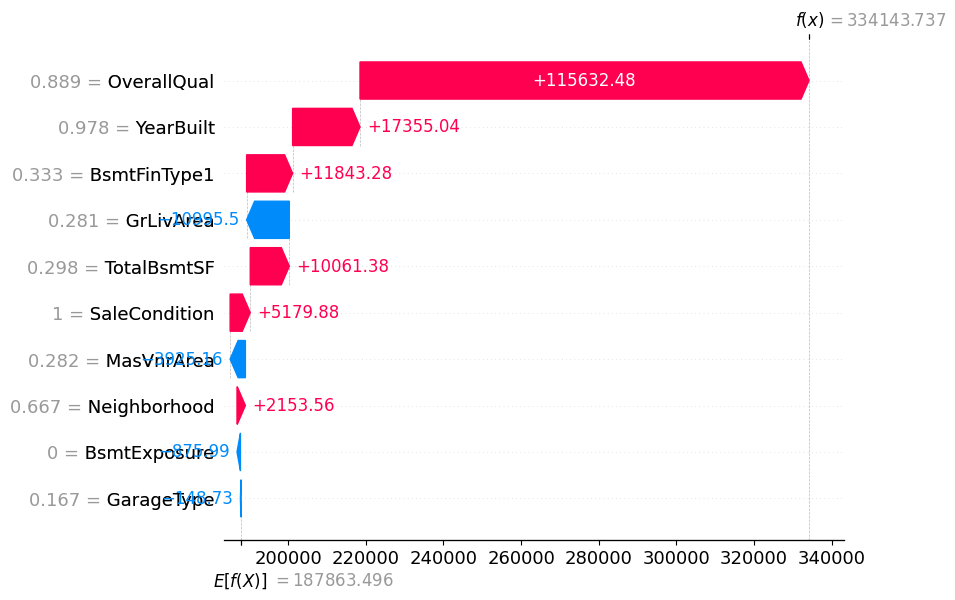

In [281]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values_lgbm[0])

Discussion:
The TotalBsmtSF has a negative impact according to this model.

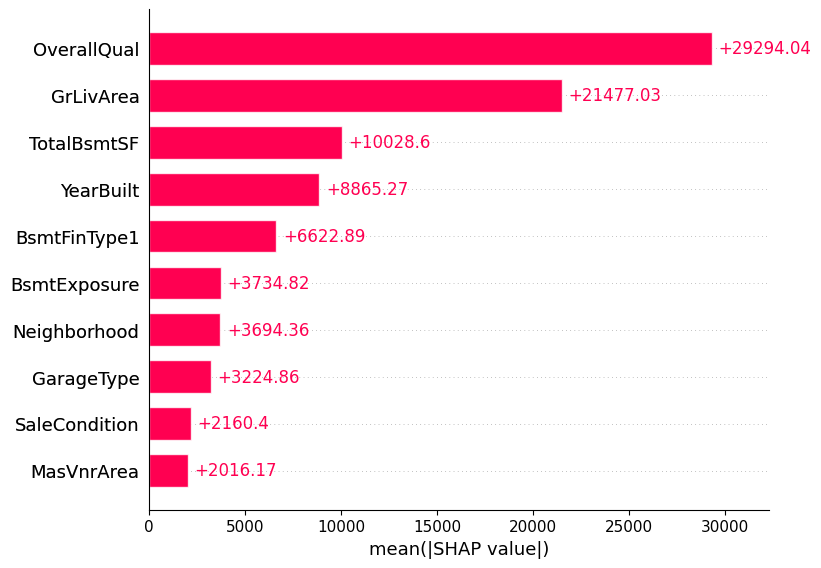

In [282]:
#Mean SHAP
shap.plots.bar(shap_values_lgbm)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


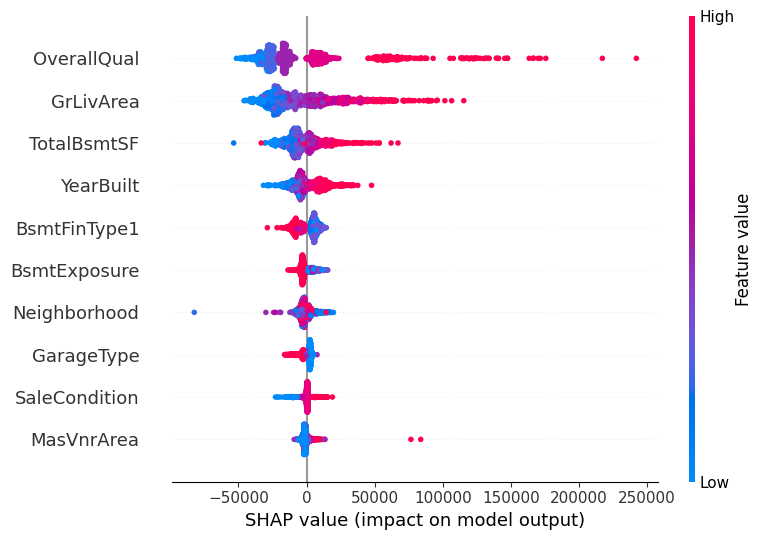

In [283]:
#Display summary plot
shap.summary_plot(shap_values_lgbm, X_train)

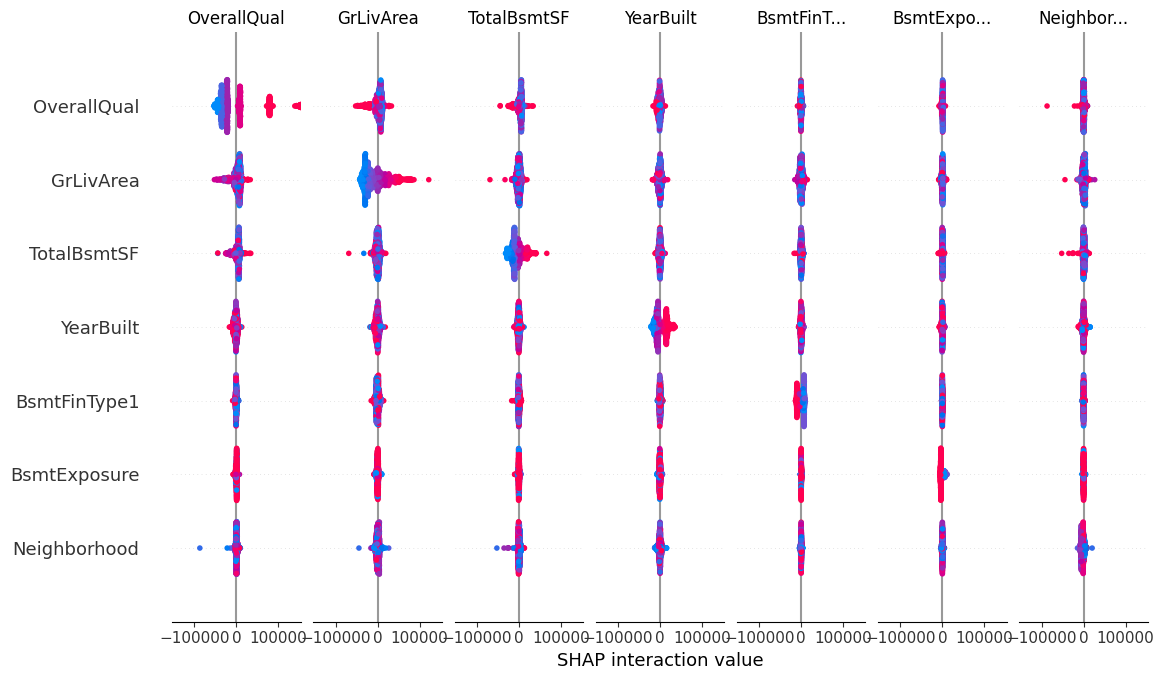

In [284]:
#Display summary plot
shap.summary_plot(shap_interaction_lgbm, X_train)

##Pickle the models for Steamlit

In [285]:
# Save LGBM baseline model
pickle.dump(reg_lgbm_baseline, open('lgbm_base.pkl', 'wb'))

# Save LightGBM model optimized with Optuna
pickle.dump(lgbmreg_optimized, open('lgbm_optimized.pkl', 'wb'))

# Save XGBoost baseline model
pickle.dump(xgb_model, open('xgb_base.pkl', 'wb'))

# Save XGBoost model optimized with Optuna
pickle.dump(xgb_optimized, open('xgb_optimized.pkl', 'wb'))

**References:**

1. https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

2. https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454

3. https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

4. https://www.kaggle.com/code/rnepal2/lightgbm-optuna-housing-prices-regression/notebook

5. https://www.kaggle.com/code/rnepal2/lightgbm-optuna-housing-prices-regression/notebook

6. https://practicaldatascience.co.uk/machine-learning/how-to-tune-an-xgbregressor-model-with-optuna